### U-Net Implementation of Monocular Depth Estimation

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import functools

if torch.cuda.is_available():
    # Set Device
    torch.cuda.set_device(0)
    print("Cuda enabled on device: {}".format(torch.cuda.current_device()))


Cuda enabled on device: 0


In [2]:
#%%writefile depthnet.py
import torch
import torch.nn as nn
from torch.nn import init
from collections import OrderedDict

def create_sublayer_dict(input_nc, output_nc, layer_index, nconvs, norm_layer, **conv_kwargs):
    sublayer=OrderedDict()
    j = 0
    sublayer.update({"conv{}_{}".format(layer_index, j): nn.Conv2d(input_nc, output_nc, **conv_kwargs)})
    j += 1
    sublayer.update({"relu{}_{}".format(layer_index, j): nn.ReLU(True)})
    for i in range(nconvs-1):
        j += 1
        sublayer.update({"conv{}_{}".format(layer_index, j): nn.Conv2d(output_nc, output_nc, **conv_kwargs)})
        j += 1
        sublayer.update({"relu{}_{}".format(layer_index, j): nn.ReLU(True)})
    if norm_layer:
        j += 1
        sublayer.update({"norm{}_{}".format(layer_index, j): norm_layer(output_nc)})
    return sublayer

class DepthNet(nn.Module):
    def __init__(self, input_nc, output_nc, norm_layer=nn.BatchNorm2d):
        super(DepthNet, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        use_bias = True

        # Conv1
#         model1=OrderedDict()
#         model1.update({"conv1_0": nn.Conv2d(input_nc, 64, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model1.update({"relu1_1": nn.ReLU(True)})
#         model1.update({"conv1_2": nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model1.update({"relu1_3": nn.ReLU(True)})
#         model1.update({"norm1_4": norm_layer(64)})
        model1 = create_sublayer_dict(input_nc, 64, 1, 2, norm_layer, 
                                      kernel_size=3, stride=1, padding=1, bias=use_bias)
        # add a subsampling operation (in self.forward())

        # Conv2
#         model2=OrderedDict()
#         model2.update({"conv2_0": nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model2.update({"relu2_1": nn.ReLU(True)})
#         model2.update({"conv2_2": nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model2.update({"relu2_3": nn.ReLU(True)})
#         model2.update({"norm2_4": norm_layer(128)})
        model2 = create_sublayer_dict(64, 128, 2, 2, norm_layer,
                                      kernel_size=3, stride=1, padding=1, bias=use_bias)
        # add a subsampling layer operation (in self.forward())

        # Conv3
#         model3=OrderedDict()
#         model3.update({"conv3_0": nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model3.update({"relu3_1": nn.ReLU(True)})
#         model3.update({"conv3_2": nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model3.update({"relu3_3": nn.ReLU(True)})
#         model3.update({"conv3_4": nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model3.update({"relu3_5": nn.ReLU(True)})
#         model3.update({"norm3_6": norm_layer(256)})
        model3 = create_sublayer_dict(128, 256, 3, 3, norm_layer,
                                      kernel_size=3, stride=1, padding=1, bias=use_bias)
        # add a subsampling layer operation

        # Conv4
#         model4=OrderedDict()
#         model4.update({"conv4_0": nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model4.update({"relu4_1": nn.ReLU(True)})
#         model4.update({"conv4_2": nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model4.update({"relu4_3": nn.ReLU(True)})
#         model4.update({"conv4_4": nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias)})
#         model4.update({"relu4_5": nn.ReLU(True)})
#         model4.update({"norm4_6": norm_layer(512)})
        model4 = create_sublayer_dict(256, 512, 4, 3, norm_layer,
                                      kernel_size=3, stride=1, padding=1, bias=use_bias)

        # Conv5
#         model5=OrderedDict()
#         model5.update({"conv5_0":nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias)})
#         model5+=[nn.ReLU(True),]
#         model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias),]
#         model5+=[nn.ReLU(True),]
#         model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias),]
#         model5+=[nn.ReLU(True),]
#         model5+=[norm_layer(512),]
        model5 = create_sublayer_dict(512, 512, 5, 3, norm_layer,
                                      kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias)

        # Conv6
#         model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias),]
#         model6+=[nn.ReLU(True),]
#         model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias),]
#         model6+=[nn.ReLU(True),]
#         model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias),]
#         model6+=[nn.ReLU(True),]
#         model6+=[norm_layer(512),]
        model6 = create_sublayer_dict(512, 512, 6, 3, norm_layer,
                                      kernel_size=3, dilation=2, stride=1, padding=2, bias=use_bias)

        # Conv7
#         model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model7+=[nn.ReLU(True),]
#         model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model7+=[nn.ReLU(True),]
#         model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model7+=[nn.ReLU(True),]
#         model7+=[norm_layer(512),]
        model7 = create_sublayer_dict(512, 512, 7, 3, norm_layer,
                                      kernel_size=3, stride=1, padding=1, bias=use_bias)

        # Conv7
        model8up=OrderedDict([("convt8_up", 
                               nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=use_bias))]
                            )
        model3short8=OrderedDict([("conv3short8",
                                   nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias))]
                                )

        model8=OrderedDict([("relu8_pre", nn.ReLU(True))])
#         model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model8+=[nn.ReLU(True),]
#         model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model8+=[nn.ReLU(True),]
#         model8+=[norm_layer(256),]
        model8.update(create_sublayer_dict(256, 256, 8, 2, norm_layer,
                                      kernel_size=3, stride=1, padding=1, bias=use_bias))

        # Conv9
        model9up=OrderedDict([("convt9_up", 
                               nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=use_bias))]
                            )
        model2short9=OrderedDict([("conv2short9",
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias))]
                                )
        # add the two feature maps above        

        model9=OrderedDict([("relu9_pre", nn.ReLU(True))])
#         model9+=[nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=use_bias),]
#         model9+=[nn.ReLU(True),]
#         model9+=[norm_layer(128),]
        model9.update(create_sublayer_dict(128, 128, 9, 1, norm_layer,
                                           kernel_size=3, stride=1, padding=1, bias=use_bias))

        # Conv10
        model10up=OrderedDict([("conv10_up", 
                               nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=use_bias))]
                             )
        model1short10=OrderedDict([("conv1short10", 
                                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=use_bias))]
                                 )
        # add the two feature maps above

        model10=OrderedDict([("relu10_pre", nn.ReLU(True))])
        model10.update({"conv10_0": nn.Conv2d(128, 128, kernel_size=3, dilation=1, stride=1, padding=1, bias=use_bias)})
        model10.update({"leakyrelu10_1": nn.LeakyReLU(negative_slope=.2)})

        # Depth Map Regression Output
        model_out=OrderedDict([("conv_out",
                                nn.Conv2d(128, 1, kernel_size=1, padding=0, dilation=1, stride=1, bias=use_bias))]
                             )
        model_out.update({"relu_out": nn.ReLU(True)}) # Depth should be in [0, +inf)

        self.model1 = nn.Sequential(model1)
        self.model2 = nn.Sequential(model2)
        self.model3 = nn.Sequential(model3)
        self.model4 = nn.Sequential(model4)
        self.model5 = nn.Sequential(model5)
        self.model6 = nn.Sequential(model6)
        self.model7 = nn.Sequential(model7)
        self.model8up = nn.Sequential(model8up)
        self.model8 = nn.Sequential(model8)
        self.model9up = nn.Sequential(model9up)
        self.model9 = nn.Sequential(model9)
        self.model10up = nn.Sequential(model10up)
        self.model10 = nn.Sequential(model10)
        self.model3short8 = nn.Sequential(model3short8)
        self.model2short9 = nn.Sequential(model2short9)
        self.model1short10 = nn.Sequential(model1short10)

        self.model_out = nn.Sequential(model_out)

#         self.upsample4 = nn.Sequential(*[nn.Upsample(scale_factor=4, mode='nearest'),])
#         self.softmax = nn.Sequential(*[nn.Softmax(dim=1),])

    def forward(self, input_A):
#         conv1_2 = self.model1(torch.cat((input_A,input_B,mask_B),dim=1))
        conv1_2 = self.model1(input_A)
        conv2_2 = self.model2(conv1_2[:,:,::2,::2]) # downsample
        conv3_3 = self.model3(conv2_2[:,:,::2,::2]) # downsample
        conv4_3 = self.model4(conv3_3[:,:,::2,::2]) # downsample
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_up = self.model8up(conv7_3) + self.model3short8(conv3_3) # Shortcut
        conv8_3 = self.model8(conv8_up)
        conv9_up = self.model9up(conv8_3) + self.model2short9(conv2_2) # Shortcut
        conv9_3 = self.model9(conv9_up)
        conv10_up = self.model10up(conv9_3) + self.model1short10(conv1_2) # Shortcut
        conv10_2 = self.model10(conv10_up)
        out_reg = self.model_out(conv10_2)

        return out_reg



In [9]:
###########
# Dataset #
###########
from PIL import Image
import torch
from torch.utils.data import Dataset
import csv, numpy as np
import os
from collections import defaultdict

from torchvision import transforms

class DepthDataset(Dataset):
    """Class for reading and storing image and depth data together.
    """
    def __init__(self, splitfile, dataDir, transform=None):
        """
        Parameters
        ----------
        images : list of (string, string)
            list of (depth_map_path, rgb_path) filepaths to depth maps and their rgb images.
        load_depth_map : function
            the function for loading this particular kind of depth_map
        load_rgb : function
            the function for loading this particular kind of image.
        """
        super(DepthDataset, self).__init__()
        self.dataDir = dataDir
        self.transform = transform
        self.data = []
        with open(splitfile, "r") as f:
            for line in f.readlines():
                self.data.append(line.strip().split(","))
#         print(self.data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        depthFile, rgbFile = self.data[idx]
        # Extract depth file:
        depthImg = Image.open(os.path.join(self.dataDir, depthFile))
        # Extract rgb file:
        rgbImg = Image.open(os.path.join(self.dataDir, rgbFile))
        sample = {"depth": depthImg, "rgb": rgbImg}
        if self.transform:
            sample = self.transform(sample)
        return sample
        




In [20]:
##############
# Transforms #
##############
# for data augmentation
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        depth, rgb = sample['depth'], sample['rgb']

        h, w = depth.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        depth = depth[top: top + new_h,
                      left: left + new_w]
        
        rgb = rgb[top: top + new_h,
                  left: left + new_w]

        return {'depth': depth, 'rgb': rgb}

class CenterCrop(object):
    """Center crop the image
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        depth, rgb = sample['depth'], sample['rgb']
        h, w = depth.shape
        new_h, new_w = self.output_size

        top = h//2 - new_h//2
        bottom = h//2 + new_h//2 + (1 if new_h % 2 else 0)
        left = w - new_w//2
        right = w + new_w//2 + (1 if new_w % 2 else 0)
        
        return {"depth": depth[top:bottom, left:right],
                "rgb": rgb[top:bottom, left:right, :]}
    
class Crop_8(object):
    """Crop to a size where both dimensions are divisible by 8"""
    
    def __call__(self, sample):
        depth, rgb = sample['depth'], sample['rgb']
        new_h, new_w = (depth.shape[0]//8)*8, (depth.shape[1]//8)*8
        return {"depth": depth[:new_h, :new_w],
                "rgb": rgb[:new_h, :new_w, :]}
        
class Crop_small(object):
    def __call__(self, sample):
        depth, rgb = sample['depth'], sample['rgb']
        h, w = depth.shape[:2]
        x = 16
        return {"depth": depth[h//2-x:h//2+x, w//2-x:w//2+x],
                "rgb": rgb[h//2-x:h//2+x, w//2-x:w//2+x, :]}

class ToFloat(object):
    """Also parses the depth info for sunrgbd."""
    def __call__(self, sample):
        depth = sample['depth']
        x = np.asarray(depth, dtype=np.int16)
        y = (x >> 3) | (x << 16-3)
        z = y.astype(np.float32)/1000
        z[z>8.] = 8.
        return {"depth": z,
                "rgb": np.asarray(sample['rgb']).astype(np.float32)}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        depth, rgb = sample['depth'], sample['rgb']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         depth = depth.transpose((2, 0, 1))
        rgb = rgb.transpose((2, 0, 1))
        return {'depth': torch.from_numpy(depth)[np.newaxis,:,:],
                'rgb': torch.from_numpy(rgb)}


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.cuda as cuda
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os.path
# Helper functions

#################
# Checkpointing #
#################
def save_checkpoint(state, is_best, filename='/output/checkpoint.pth.tar', always_save=False):
    """Save checkpoint if a new best is achieved"""
    if is_best or always_save:
        print ("=> Saving checkpoint to: {}".format(filename))
        torch.save(state, filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

##############
# Validation #
##############
def validate(loss, model, val_loader):
    """Computes the validation error of the model on the validation set.
    val_loader should be a DataLoader.
    
    Returns an ordinary number (i.e. not a tensor)
    
    """
    
    it = None
    losses = []
    for it, data in enumerate(val_loader):
        depth = data["depth"].float()
        rgb = data["rgb"].float()
        if torch.cuda.is_available():
            depth = depth.cuda()
            rgb = rgb.cuda()
        rgb.requires_grad=False
        output = model(rgb)
        losses.append(loss(output, depth).item())
    nbatches = it+1
    return sum(losses)/nbatches

##################
# Viewing Images #
##################
def save_images(*batches, outputDir, filename):
    """
    Given a list of tensors of size (B, C, H, W) (batch, channels, height, width) torch.Tensor
    Saves each entry of the batch as an rgb or grayscale image, depending on how many channels
    the image has.
    """
    I = None
    trans = transforms.ToPILImage()
    for batchnum, batch in enumerate(batches):
        if batch.shape[1] == 3:
            pass
        elif batch.shape[1] == 1:
            batch /= torch.max(batch) # normalize to lie in [0, 1]
        else:
            raise ValueError("Unsupported number of channels: {}".format(batch.shape[1]))
        batch = batch.type(torch.float32)
        for img in range(batch.shape[0]):            
            I = trans(batch[img,:,:,:].cpu().detach())
            I.save(os.path.join(outputDir, filename + "_{}_{}.png".format(batchnum, img)))


############
# Plotting #
############
def save_train_val_loss_plots(trainlosses, vallosses, epoch):
    # Train loss
    fig = plt.figure()
    plt.plot(trainlosses)
    plt.title("Train loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig("trainloss_epoch{}.png".format(epoch))
    # Train loss
    fig = plt.figure()
    plt.plot(trainlosses)
    plt.title("Val loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.savefig("Val loss{}.png".format(epoch))

In [22]:
# Load training data
train_txt = "data/sunrgbd_nyu/train.txt"
trainDir = "data/sunrgbd_nyu"
train = DepthDataset(train_txt, trainDir, 
                     transform = transforms.Compose([ToFloat(), RandomCrop((400, 320)), ToTensor()])
#                      transform=transforms.Compose([ToFloat(), Crop_8(), ToFloat(), ToTensor()])
#                      transform=transforms.Compose([ToFloat(), Crop_small(), ToFloat(), ToTensor()])
                    )

print("Loaded training dataset from {} with size {}.".format(train_txt, len(train)))

dev_txt = "data/sunrgbd_nyu/dev.txt"
devDir = "data/sunrgbd_nyu"
dev = DepthDataset(dev_txt, devDir, 
                     transform = transforms.Compose([ToFloat(), CenterCrop((400, 320)), ToTensor()])
#                      transform=transforms.Compose([ToFloat(), Crop_8(), ToTensor()])
#                      transform=transforms.Compose([ToFloat(), Crop_small(), ToTensor()])
                    )
print("Loaded dev dataset from {} with size {}.".format(dev_txt, len(dev)))



Loaded training dataset from data/sunrgbd_nyu/train.txt with size 1159.
Loaded dev dataset from data/sunrgbd_nyu/dev.txt with size 145.


In [25]:
# Set up training.
import torch.optim as optim

checkpointfile = None
# lam = 1e-8 # Weight decay parameter for L2 regularization
learning_rate = 1e-3
num_epochs = 30
batch_size = 10

# Build model and loss
# Hyperparameters
input_nc = 3
output_nc = 1

model = DepthNet(input_nc, output_nc)

#################
# Loss function #
#################

def berhu_loss(prediction, target):
    diff = prediction - target
    threshold = 0.2*torch.max(torch.abs(prediction - target))
    c = threshold.detach()
    l2_part = torch.sum((diff**2 + c**2))/(2*c)
    l1_part = torch.sum(torch.abs(diff))
    return l1_part+l2_part

# loss = nn.SmoothL1Loss()
# loss = berhu_loss
loss = nn.MSELoss()

if torch.cuda.is_available():
    model.cuda()
    loss.cuda()

# Checkpointing
if checkpointfile is not None:
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpointfile)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(checkpointfile,
                                map_location=lambda storage,
                                loc: storage)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    trainlosses = checkpoint['trainlosses']
#     vallosses = checkpoint['vallosses']
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights, checkpoint['epoch']))
else:
    start_epoch = 0
    best_loss = torch.FloatTensor([float('inf')])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trainlosses = []
    vallosses = []
    # Initialize weights:
    for name, param in model.named_parameters():
        if "conv" in name and "weight" in name:
            print(name)
            nn.init.xavier_normal_(param)
        if "norm" in name and "weight" in name:
            print(name)
            nn.init.constant_(param, 1)
        elif "bias" in name:
            nn.init.constant_(param, 0)
            
# Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 20], gamma=0.1)

# Print summary of setup:
print("loaded checkpointfile: {}".format(checkpointfile))
print("start_epoch: {}".format(start_epoch))
print("optimizer: {}".format(optimizer))
print("batch_size: {}".format(batch_size))
print("num_epochs: {}".format(num_epochs))
print("learning rate (initial): {}".format(learning_rate))

model1.conv1_0.weight
model1.conv1_2.weight
model1.norm1_4.weight
model2.conv2_0.weight
model2.conv2_2.weight
model2.norm2_4.weight
model3.conv3_0.weight
model3.conv3_2.weight
model3.conv3_4.weight
model3.norm3_6.weight
model4.conv4_0.weight
model4.conv4_2.weight
model4.conv4_4.weight
model4.norm4_6.weight
model5.conv5_0.weight
model5.conv5_2.weight
model5.conv5_4.weight
model5.norm5_6.weight
model6.conv6_0.weight
model6.conv6_2.weight
model6.conv6_4.weight
model6.norm6_6.weight
model7.conv7_0.weight
model7.conv7_2.weight
model7.conv7_4.weight
model7.norm7_6.weight
model8up.convt8_up.weight
model8.conv8_0.weight
model8.conv8_2.weight
model8.norm8_4.weight
model9up.convt9_up.weight
model9.conv9_0.weight
model9.norm9_2.weight
model10up.conv10_up.weight
model10.conv10_0.weight
model3short8.conv3short8.weight
model2short9.conv2short9.weight
model1short10.conv1short10.weight
model_out.conv_out.weight
loaded checkpointfile: None
start_epoch: 0
optimizer: Adam (
Parameter Group 0
    amsgrad:

In [ ]:
####################
# Run the training #
####################
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dev, batch_size=5, shuffle=True, num_workers=1)

for epoch in range(start_epoch, num_epochs):
    print("epoch: {}".format(epoch))
    data = None
    output = None
    for it, data in enumerate(train_loader):
        depth = data["depth"].float()
        rgb = data["rgb"].float()
#         print('ok')


        if torch.cuda.is_available():
            depth = depth.cuda()
            rgb = rgb.cuda()
        # New batch
#         print(rgb.dtype)
        scheduler.optimizer.zero_grad()
        output = model(rgb)
        
        # Save the first batch output of every epoch
        
#         a = list(model.parameters())[0].clone()

        trainloss = loss(output, depth)
        trainloss.backward()
#         print(list(model.parameters())[0].grad)
        scheduler.optimizer.step()
#         print(depth)
#         print(output)
#         b = list(model.parameters())[0].clone()

        if not (it % 10):
            print("\titeration: {}\ttrain loss: {}".format(it, trainloss.item()))
        trainlosses.append(trainloss.item())
        
        # TESTING:
#         if not ((it + 1) % 5):
#             # Stop after 5 batches
#             break

#         print(torch.equal(a.data, b.data))
    # Checkpointing
    # Get bool not ByteTensor"
    valloss = validate(loss, model, val_loader)
    print("End epoch {}\tval loss: {}".format(epoch, valloss))
    vallosses.append(valloss)

    # Save the last batch output of every epoch
    save_images(data["rgb"], data["depth"], output, outputDir="images", filename="epoch_{}".format(epoch))
    
    is_best = bool(trainloss.data.cpu().numpy() < best_loss.numpy())
    # Get greater Tensor to keep track best acc
    best_loss = torch.FloatTensor(min(trainloss.data.cpu().numpy(), best_loss.numpy()))
    # Save checkpoint
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optim_state_dict': optimizer.state_dict(),
        'trainlosses': trainlosses,
        'vallosses': vallosses
    }, is_best, filename="checkpoints/checkpoint_epoch_{}.pth.tar".format(epoch), always_save=True)
    

epoch: 0
	iteration: 0	train loss: 6.660920143127441
	iteration: 10	train loss: 5.001108646392822
	iteration: 20	train loss: 4.368201732635498
	iteration: 30	train loss: 4.636993885040283
	iteration: 40	train loss: 4.026307582855225
	iteration: 50	train loss: 4.151325702667236
	iteration: 60	train loss: 2.713653564453125
	iteration: 70	train loss: 7.817407131195068
	iteration: 80	train loss: 7.717471122741699
	iteration: 90	train loss: 7.311159610748291
	iteration: 100	train loss: 5.854341983795166
	iteration: 110	train loss: 3.552532911300659
End epoch 0	val loss: 4.129573836408812
=> Saving checkpoint to: checkpoints/checkpoint_epoch_0.pth.tar
epoch: 1
	iteration: 0	train loss: 3.346029758453369
	iteration: 10	train loss: 4.425172328948975
	iteration: 20	train loss: 3.7099063396453857
	iteration: 30	train loss: 4.798088073730469
	iteration: 40	train loss: 4.025942325592041
	iteration: 50	train loss: 6.871330261230469
	iteration: 60	train loss: 4.025509357452393
	iteration: 70	train l

	iteration: 70	train loss: 4.5194854736328125
	iteration: 80	train loss: 4.56994104385376
	iteration: 90	train loss: 3.959199905395508
	iteration: 100	train loss: 2.840179681777954
	iteration: 110	train loss: 1.8852673768997192
End epoch 12	val loss: 3.964126634186712
=> Saving checkpoint to: checkpoints/checkpoint_epoch_12.pth.tar
epoch: 13
	iteration: 0	train loss: 7.416388511657715
	iteration: 10	train loss: 3.169062614440918
	iteration: 20	train loss: 4.655360698699951
	iteration: 30	train loss: 2.8012311458587646
	iteration: 40	train loss: 3.263439655303955
	iteration: 50	train loss: 3.7320077419281006
	iteration: 60	train loss: 3.603193759918213
	iteration: 70	train loss: 4.2478532791137695
	iteration: 80	train loss: 2.9094114303588867
	iteration: 90	train loss: 3.6379082202911377
	iteration: 100	train loss: 6.977484226226807
	iteration: 110	train loss: 2.7691147327423096
End epoch 13	val loss: 3.8417478758713295
=> Saving checkpoint to: checkpoints/checkpoint_epoch_13.pth.tar
ep

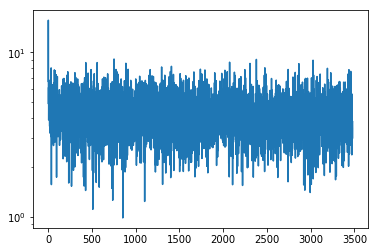

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize training loss
checkpoint = torch.load("checkpoints/checkpoint_epoch_29.pth.tar")
trainlosses = checkpoint['trainlosses']
plt.semilogy(trainlosses)





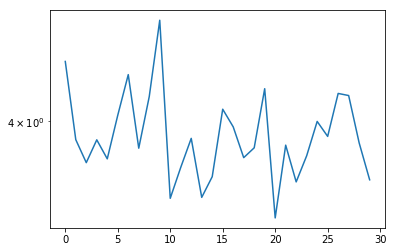

In [28]:
# Visualize training loss

trainlosses = checkpoint['vallosses']
plt.semilogy(trainlosses)

In [ ]:
%matplotlib inline
from matplotlib.pyplot import imshow
print(type(rgb))
imshow(rgb)


In [ ]:
# Training
# Load data
a = torch.ones(1, requires_grad=True)
b = torch.ones(1, requires_grad=True)

In [ ]:
c = a + b
c.register_hook(print)
s = a**2 + b**2
s.register_hook(print)

In [ ]:
# e = torch.sum(c)
e = c.detach()
f = torch.sum(s)
g = f/e
g.backward()
# s.backward()
# f.backward()

In [ ]:
a.grad